In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
            
        self.fc = FullyConnected([32*2*2, 10])
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
        
    def forward(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        self.h = self.fc(flatten)
        return self.h
    
    def loss(self, output, target):
        self._loss = F.cross_entropy(output, target)
        return self._loss

In [7]:
# models = {'SGD': Net(False, False, 'SGD', lr=1e-4),
#           'momentum': Net(False, False, 'SGD', lr=1e-4, momentum=0.9),
#           'RMSProp': Net(False, False, 'RMSProp', lr=1e-4),
#           'RMSProp+bn': Net(True, False, 'RMSProp', lr=1e-4),
#           'Adam': Net(False, False, 'Adam', lr=1e-4), 
#           'Adam+bn': Net(True, False, 'Adam', lr=1e-4), 
#          }

models = {'Adam': Net(False, False, optim_type='Adam', lr=1e-4),}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [9]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [10]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam: 2.3082
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam: 1.5227
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam: 0.8559
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam: 0.6931
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam: 0.4653
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam: 0.3906
Test losses: Adam: 0.4881
Train Epoch: 2 [0/50000 (0%)]	Losses Adam: 0.6588
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam: 0.3422
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam: 0.3448
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam: 0.4669
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam: 0.3936
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam: 0.5954
Test losses: Adam: 0.3543
Train Epoch: 3 [0/50000 (0%)]	Losses Adam: 0.3284
Train Epoch: 3 [10000/50000 (20%)]	Losses Adam: 0.3382
Train Epoch: 3 [20000/50000 (40%)]	Losses Adam: 0.1454
Train Epoch: 3 [30000/50000 (60%)]	Losses Adam: 0.2694
Train Epoch: 3 [40000/50000 (80%)]	Losses Adam: 0.3189
Train Epoch: 3 [50000/5000

KeyboardInterrupt: 

In [57]:
img_w = nn.Parameter(torch.Tensor(size=[10, 1, 28, 28]))
img_optim = optim.Adam(params=[img_w], lr=1e-2)

In [58]:
target = torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(torch.long)

In [59]:
for i in range(10000):
    img_optim.zero_grad()
    img = F.sigmoid(img_w)
    latent = models['Adam'](img)
    loss = F.cross_entropy(latent, target)
    loss.backward()
    img_optim.step()
    if i%1000 == 0:
        print(loss.item())

7.123481750488281
1.7395658493041992
1.588777780532837
1.5413315296173096
1.5194791555404663
1.512569785118103
1.5096595287322998
1.5079667568206787
1.5069161653518677
1.506453275680542


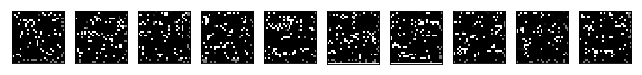

In [62]:
img = F.sigmoid(img_w)
plot_mnist(img.detach().numpy(), (1, 10)) 

In [63]:
img_w = nn.Parameter(torch.Tensor(size=[32, 1, 18, 18]))
img_optim = optim.Adam(params=[img_w], lr=1e-2)
target = torch.eye(32)

In [65]:
for i in range(10000):
    img_optim.zero_grad()
    img = F.sigmoid(img_w)
    latent, _, _ = models['Adam'].conv(img)
    loss = F.mse_loss(latent.view(32, 32), target)
    loss.backward()
    img_optim.step()
    if i%1000 == 0:
        print(loss.item())

0.631602942943573
0.11538110673427582
0.09108186513185501
0.08357284963130951
0.07798062264919281
0.07621040940284729
0.07524432241916656
0.07395229488611221
0.07334844768047333
0.07289817184209824


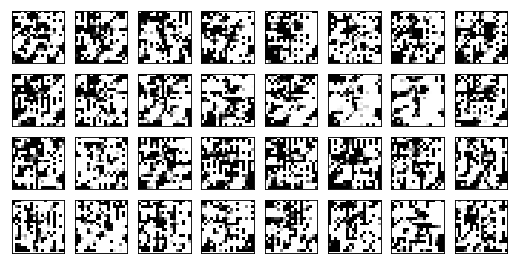

In [66]:
img = F.sigmoid(img_w)
plot_mnist(img.detach().numpy(), (4, 8)) 

In [69]:
img_w = nn.Parameter(torch.Tensor(size=[16, 1, 4, 4]))
img_optim = optim.Adam(params=[img_w], lr=1e-2)
target = torch.eye(16)

In [70]:
for i in range(3000):
    img_optim.zero_grad()
    img = F.sigmoid(img_w)
    latent = models['Adam']._conv1(img)
    loss = F.mse_loss(latent.view(16, 16), target)
    loss.backward()
    img_optim.step()
    if i%1000 == 0:
        print(loss.item())

0.447405606508255
0.07336782664060593
0.06873548775911331


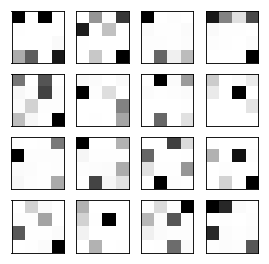

In [71]:
img = F.sigmoid(img_w)
plot_mnist(img.detach().numpy(), (4, 4)) 